In [1]:
##### Params
path_train_set = "./Data/Patches_train/"
path_test_set = "./Data/Patches_test/"

In [2]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models as model
from torch.utils.data import random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()])

batch_size = 32

train_set = ImageFolder(path_train_set, transform=transform)
test_set = ImageFolder(path_test_set, transform=transform)

train_size = int(0.85 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = random_split(train_set, [train_size, valid_size])

train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valid_loader = T.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [4]:
class Net(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 9 * 9, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x


In [5]:
net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=41472, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(inpl

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.001, lr_decay=0, weight_decay=0.004, initial_accumulator_value=0, eps=1e-10)

In [7]:
## j'ai juste tout foutu dans une fonction pour pouvoir arrêter le training et return le model de la current epoch
## dès que la validation acc dépasse ce qu'on veut

def mainLoop():
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range(0, 60):
        net.train()
        running_loss = .0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):

            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss /= len(train_loader)
        train_loss.append(running_loss)
        running_acc = correct / total
        train_acc.append(running_acc)

        if epoch % 10 == 0 or True:
            print('\nEpoch: {}'.format(epoch))
            print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
            print('Train Loss => {:.5f}'.format(running_loss))

        # VALIDATION LOOP
        with T.no_grad():
            correct = 0
            total = 0
            valid_running_loss = .0
            for data in valid_loader:
                inputs, labels = data
                if device == 'cuda':
                    inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                valid_running_loss += loss.item()
                _, predicted = T.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            valid_running_loss /= len(valid_loader)
            valid_loss.append(valid_running_loss)
            valid_running_acc = correct / total
            valid_acc.append(valid_running_acc)
            
            if epoch % 10 == 0 or True:
                print('valid Acc.  => {:.3f}%'.format(100 * valid_running_acc), end=' | ')
                print('valid Loss  => {:.5f}'.format(valid_running_loss))
            """
            if (100 * valid_running_acc) > 73:
                print('>70 returned')
                return net,train_loss,train_acc,valid_loss,valid_acc
            """
            
    print('Finished Training')
    return net,train_loss,train_acc,valid_loss,valid_acc

In [8]:
net,train_loss,train_acc,valid_loss,valid_acc = mainLoop()


Epoch: 0
Train Acc. => 58.328% | Train Loss => 0.67758
valid Acc.  => 59.780% | valid Loss  => 0.66525

Epoch: 1
Train Acc. => 64.920% | Train Loss => 0.63497
valid Acc.  => 63.196% | valid Loss  => 0.64633

Epoch: 2
Train Acc. => 66.378% | Train Loss => 0.62238
valid Acc.  => 63.306% | valid Loss  => 0.64539

Epoch: 3
Train Acc. => 66.262% | Train Loss => 0.61942
valid Acc.  => 65.014% | valid Loss  => 0.63066

Epoch: 4
Train Acc. => 66.174% | Train Loss => 0.61517
valid Acc.  => 65.620% | valid Loss  => 0.62496

Epoch: 5
Train Acc. => 67.185% | Train Loss => 0.61139
valid Acc.  => 65.124% | valid Loss  => 0.62446

Epoch: 6
Train Acc. => 66.932% | Train Loss => 0.60961
valid Acc.  => 65.840% | valid Loss  => 0.62127

Epoch: 7
Train Acc. => 67.117% | Train Loss => 0.60962
valid Acc.  => 65.455% | valid Loss  => 0.62166

Epoch: 8
Train Acc. => 67.428% | Train Loss => 0.60769
valid Acc.  => 65.455% | valid Loss  => 0.62242

Epoch: 9
Train Acc. => 67.409% | Train Loss => 0.60556
valid Ac

KeyboardInterrupt: 

In [9]:
#####
# Test loop pour obtenir accuracy pour chaque classe
#####


classes = ('Good','Bad')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with T.no_grad():
    for data in test_loader:
        images, labels = data
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = T.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy pour la classe: {classname:5s} is {accuracy:.1f} %')

Accuracy pour la classe: Good  is 59.8 %
Accuracy pour la classe: Bad   is 77.8 %


In [10]:
#####
# Test loop pour obtenir accuracy pour chaque classe
#####

correct = 0
total = 0

with T.no_grad():
    for data in test_loader:
        images, labels = data
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy complète sur le test set: {100 * correct // total} %')

Accuracy complète sur le test set: 68 %


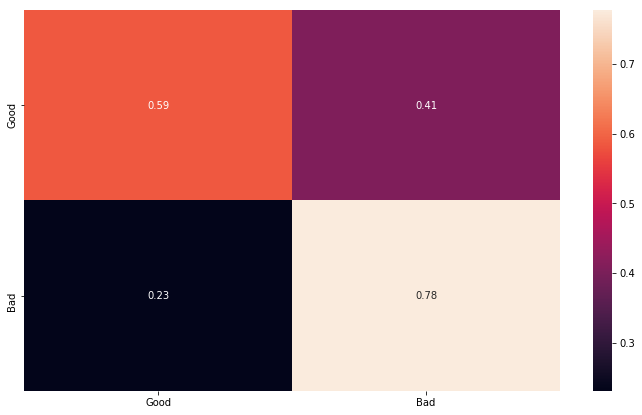

In [12]:
import seaborn as sn
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix


y_pred = []
y_true = []

# on parcours test data
for inputs, labels in test_loader:
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
            
        # envoie dans le modèle
        output = net(inputs)
        
        # on regarde la prédiction
        output = (T.max(T.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        # et on sauvegarde le vrai label
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
        
classes = ('Good', 'Bad')

#cf_matrix = confusion_matrix(y_true, y_pred,normalize='true')
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [13]:
#T.save(net.state_dict(), "path")
T.save(net, "trained_net")